# Melt, Weather --> LSTM --> streamflow

In [38]:
#first: are you working in colab?
colab = 1

if colab:
    
    #mount drive
    from google.colab import drive
    drive.mount('/content/drive')
    
    dataPath = '/content/drive/My Drive/Colab Notebooks/T_P_F_pca_lstm/'
    
else:
    
    dataPath = ''


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#import required libraries
import pandas as pd
import numpy as np
#from netCDF4 import Dataset
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
import keras
import pickle
import matplotlib.pyplot as plt

In [0]:
#define NSE

def nse(y_obs, y_model):

  """
  nse = nse(y_obs, y_model)
  """

  y_model = y_model.reshape((-1,1))
  y_obs = y_obs.reshape((-1,1))
  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2)
  return nse

In [0]:
#M = pd.read_csv(dataPath + 'stationGlacierMelt.csv',header=None)
M = pd.read_csv(dataPath + 'stationGlacierRunoff.csv',header=None)

pickle_in = open(dataPath + 'flowDict.pickle','rb')
flowDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'tempDict.pickle','rb')
tempDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'precDict.pickle','rb')
precDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'relHDict.pickle','rb')
relHDict = pickle.load(pickle_in)

pickle_in = open(dataPath + 'ssrdDict.pickle','rb')
ssrdDict = pickle.load(pickle_in)

#unpack data

stationLat = flowDict['stationLat']
stationLon = flowDict['stationLon']
eraLat = tempDict['latERA']
eraLon = tempDict['lonERA']

flowDays = flowDict['windowDays']
flowMonths = flowDict['windowMonths']
flowYears = flowDict['windowYears']
eraDays = tempDict['daysERA']
eraMonths = tempDict['monthsERA']
eraYears = tempDict['yearsERA']

F = flowDict['all_flowwindow_norm_NF'] #normalized discharge with nans filled (NF)
T = tempDict['T']
P = precDict['P']
H = relHDict['H']
S = ssrdDict['S']

In [0]:
#make data have same time range
startYear = max(int(np.min(eraYears)),int(np.min(flowYears)))

indStartERA = min(np.argwhere(eraYears==startYear))[0]
indStartFlow = min(np.argwhere(flowYears==startYear))[0]

F = np.asarray(np.transpose(np.squeeze(F[indStartFlow:])))
T = np.asarray(T[indStartERA:])
P = np.asarray(P[indStartERA:])
H = np.asarray(H[indStartERA:])
S = np.asarray(S[indStartERA:])
M = np.asarray(M.iloc[:,indStartERA:])

##just alberta
#T = T[:,:15,29:]
#P = P[:,:15,29:]
#H = H[:,:15,28:]
#S = S[:,:15,28:]

flowDays = flowDays[indStartFlow:]
flowMonths = flowMonths[indStartFlow:]
flowYears = flowYears[indStartFlow:]

eraDays = eraDays[indStartERA:]
eraMonths = eraMonths[indStartERA:]
eraYears = eraYears[indStartERA:]

In [0]:
#loop through stations and find the closest era grid cell

stationT = np.empty((len(stationLat),len(eraDays)))
stationP = np.empty((len(stationLat),len(eraDays)))
stationH = np.empty((len(stationLat),len(eraDays)))
stationS = np.empty((len(stationLat),len(eraDays)))
stationM = np.empty((len(stationLat),len(eraDays)))

for kk in range(len(stationLat)): #for each station
    
    dlat = np.min(np.abs(stationLat[kk] - eraLat))
    indLat = np.argwhere(np.abs(stationLat[kk] - eraLat) == dlat)[0]
    dlon = np.min(np.abs(stationLon[kk] - eraLon))
    indLon = np.argwhere(np.abs(stationLon[kk] - eraLon) == dlon)[0]
    
    stationT[kk] = np.squeeze(T[:,indLat,indLon])
    stationP[kk] = np.squeeze(P[:,indLat,indLon])
    stationH[kk] = np.squeeze(H[:,indLat,indLon])
    stationS[kk] = np.squeeze(S[:,indLat,indLon])
    stationM[kk] = np.squeeze(M[kk])
    
#use only stations with glaciers
stationsWithGlaciers = np.squeeze(np.argwhere(np.sum(stationM,axis=1)>0))
stationT = stationT[stationsWithGlaciers,:]
stationP = stationP[stationsWithGlaciers,:]
stationH = stationH[stationsWithGlaciers,:]
stationS = stationS[stationsWithGlaciers,:]
stationM = stationM[stationsWithGlaciers,:]
F = F[:,stationsWithGlaciers]

#normalize
stationT = (stationT - np.mean(stationT))/np.std(stationT)
stationP = (stationP - np.mean(stationP))/np.std(stationP)
stationH = (stationH - np.mean(stationH))/np.std(stationH)
stationS = (stationS - np.mean(stationS))/np.std(stationS)
stationM = (stationM - np.mean(stationM))/np.std(stationM)


In [0]:
for station in range(np.shape(F)[1]):
    #F[:,station] = (F[:,station] - np.mean(F[:,station]))/np.std(F[:,station])
    minF = np.min(F[:,station])
    maxF = 2 * np.std(F[:,station])
    F[:,station] = (F[:,station] - minF) / (maxF - minF)
    
    for inds in np.argwhere(F>4):
      F[inds[0],inds[1]] = 4
  

In [0]:
#create input/output datasets

num_stations = 5

num_obs = (len(eraDays) - 365) * num_stations #len(stationsWithGlaciers)

x = np.empty((num_obs,365,5))
y = np.empty((num_obs))

jj = 0

for station in range(num_stations): #range(len(stationsWithGlaciers)): #for each station
    
    for day in range(len(eraDays)-365): #for each day of flow
        
        x[jj,:,0] = stationT[station,day:day+365]
        x[jj,:,1] = stationP[station,day:day+365]
        x[jj,:,2] = stationH[station,day:day+365]
        x[jj,:,3] = stationS[station,day:day+365]
        x[jj,:,4] = stationM[station,day:day+365]
        y[jj] = F[day+365,station]
        jj+=1
    

In [0]:
#split into train/test
fracTrain = 0.8
Ntrain = int(fracTrain * len(x))

x_train = x[:Ntrain]
y_train = y[:Ntrain]

x_test = x[Ntrain:]
y_test = y[Ntrain:]

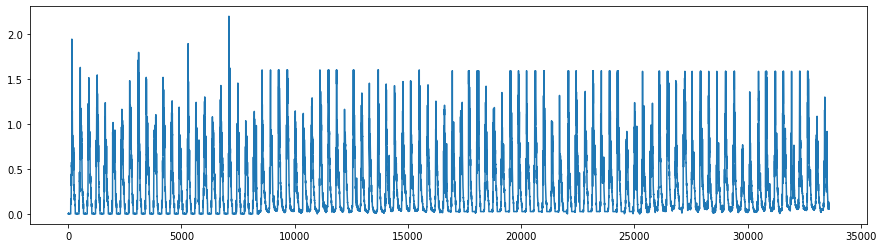

In [53]:
plt.figure(figsize=(15,4))
plt.plot(y_train)


In [54]:
#build model

model = Sequential()
model.add(LSTM(20, 
               input_shape = (365,5), 
               return_sequences = True,
               #return_state = True,
               kernel_regularizer = regularizers.l2(0.001)))
model.add(Dropout(rate = 0.1))
model.add(LSTM(20, 
               input_shape = (365,5), 
               return_sequences = True,
               #return_state = True,
               kernel_regularizer = regularizers.l2(0.001)))
model.add(Flatten())
model.add(Dense(1,
                activation = 'linear'))
model.compile(loss = 'mse', 
              optimizer=keras.optimizers.Adam(lr=0.005))
model.summary()

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience = 5)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 365, 20)           2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 365, 20)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 365, 20)           3280      
_________________________________________________________________
flatten_4 (Flatten)          (None, 7300)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7301      
Total params: 12,661
Trainable params: 12,661
Non-trainable params: 0
_________________________________________________________________


In [55]:
#train model

batch_size = 512
epochs = 10
history = model.fit(x_train,y_train, 
                    validation_split = 0.2, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    verbose = 1, 
                    callbacks = [es])

Train on 26883 samples, validate on 6721 samples
Epoch 1/10
26883/26883 [==============================] - 84s 3ms/step - loss: 0.0836 - val_loss: 0.0466
Epoch 2/10
26883/26883 [==============================] - 82s 3ms/step - loss: 0.0354 - val_loss: 0.0390
Epoch 3/10
26883/26883 [==============================] - 82s 3ms/step - loss: 0.0307 - val_loss: 0.0366
Epoch 4/10
26883/26883 [==============================] - 81s 3ms/step - loss: 0.0267 - val_loss: 0.0321
Epoch 5/10
26883/26883 [==============================] - 81s 3ms/step - loss: 0.0245 - val_loss: 0.0310
Epoch 6/10
26883/26883 [==============================] - 81s 3ms/step - loss: 0.0222 - val_loss: 0.0293
Epoch 7/10
26883/26883 [==============================] - 81s 3ms/step - loss: 0.0212 - val_loss: 0.0283
Epoch 8/10
26883/26883 [==============================] - 81s 3ms/step - loss: 0.0191 - val_loss: 0.0264
Epoch 9/10
26883/26883 [==============================] - 81s 3ms/step - loss: 0.0179 - val_loss: 0.0304
Epoch 

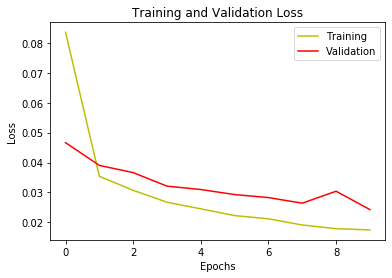

In [56]:
saveIt = 0

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(loss, 'y', label='Training')
plt.plot(val_loss, 'r', label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.xlim((1,10))
#plt.ylim((0,.1))
#plt.show()

if saveIt:
  plt.savefig('loss.png')

In [0]:
#predict streamflow with trained model
#y_trainPredict = model.predict(x_train)
y_testPredict = model.predict(x_test)

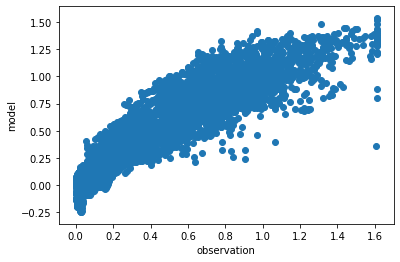

In [58]:
#visualize
plt.scatter(y_test,y_testPredict)
plt.xlabel('observation')
plt.ylabel('model')

if saveIt:
  plt.savefig('obs_vs_model.png')

In [59]:
#compute NSE

NSE = nse(y_test,y_testPredict)
print('NSE = ' + str(NSE)[:4])

NSE = 0.87


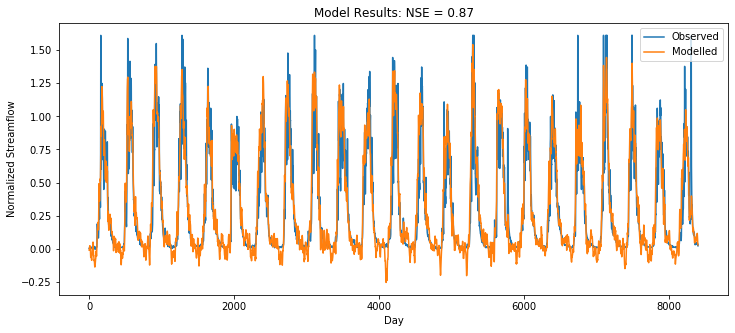

In [60]:
#visualize more

saveIt = 0

plt.figure(figsize = (12,5))
plt.plot(y_test, label = 'Observed')
plt.plot(y_testPredict, label = 'Modelled')
#plt.xlim((4500,6000))
plt.legend()
plt.xlabel('Day')
plt.ylabel('Normalized Streamflow')
plt.title('Model Results: NSE = ' + str(NSE)[:4])
#plt.show()

if saveIt:
  plt.savefig('modelled_time_series.png')

In [0]:
#create input/output datasets

num_stations = 1

num_obs = (len(eraDays) - 365) * num_stations #len(stationsWithGlaciers)

x = np.empty((num_obs,365,5))
y = np.empty((num_obs))

jj = 0

for station in range(num_stations): #range(len(stationsWithGlaciers)): #for each station
    
    for day in range(len(eraDays)-365): #for each day of flow
        
        x[jj,:,0] = stationT[station,day:day+365]
        x[jj,:,1] = stationP[station,day:day+365]
        x[jj,:,2] = stationH[station,day:day+365]
        x[jj,:,3] = stationS[station,day:day+365]
        x[jj,:,4] = stationM[station,day:day+365]
        y[jj] = F[day+365,station]
        jj+=1

In [0]:
#split into train/test
fracTrain = 0.8
Ntrain = int(fracTrain * len(x))

x_train = x[:Ntrain]
y_train = y[:Ntrain]

x_test = x[Ntrain:]
y_test = y[Ntrain:]

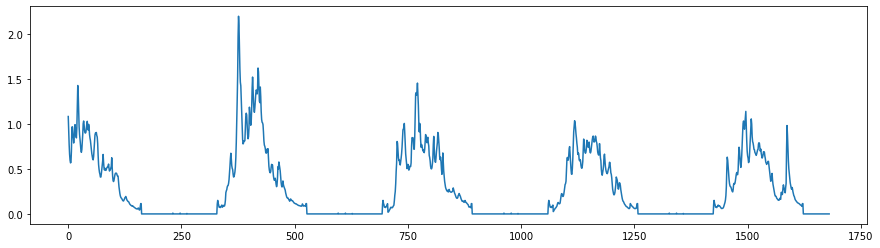

In [63]:
plt.figure(figsize=(15,4))
plt.plot(y_test)

In [64]:
#train model

batch_size = 512
epochs = 10
history = model.fit(x_train,y_train, 
                    validation_split = 0.2, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    verbose = 1, 
                    callbacks = [es])

Train on 5376 samples, validate on 1344 samples
Epoch 1/10
5376/5376 [==============================] - 17s 3ms/step - loss: 0.0136 - val_loss: 0.0133
Epoch 2/10
5376/5376 [==============================] - 17s 3ms/step - loss: 0.0120 - val_loss: 0.0140
Epoch 3/10
5376/5376 [==============================] - 17s 3ms/step - loss: 0.0113 - val_loss: 0.0138
Epoch 4/10
5376/5376 [==============================] - 17s 3ms/step - loss: 0.0103 - val_loss: 0.0128
Epoch 5/10
5376/5376 [==============================] - 17s 3ms/step - loss: 0.0100 - val_loss: 0.0132
Epoch 6/10
5376/5376 [==============================] - 17s 3ms/step - loss: 0.0096 - val_loss: 0.0137
Epoch 7/10
5376/5376 [==============================] - 17s 3ms/step - loss: 0.0090 - val_loss: 0.0151
Epoch 8/10
5376/5376 [==============================] - 17s 3ms/step - loss: 0.0089 - val_loss: 0.0161
Epoch 9/10
5376/5376 [==============================] - 17s 3ms/step - loss: 0.0085 - val_loss: 0.0160
Epoch 00009: early stoppi

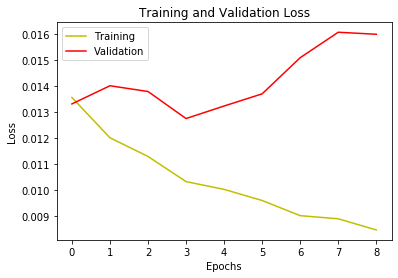

In [65]:
saveIt = 0

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(loss, 'y', label='Training')
plt.plot(val_loss, 'r', label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.ylim((0,1))
#plt.show()

if saveIt:
  plt.savefig('loss.png')

In [0]:
#predict streamflow with trained model
#y_trainPredict = model.predict(x_train)
y_testPredict = model.predict(x_test)

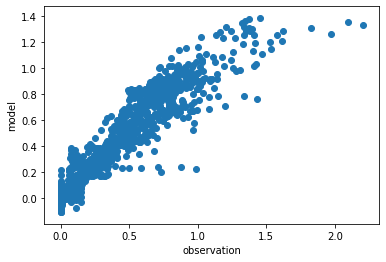

In [67]:
#visualize
plt.scatter(y_test,y_testPredict)
plt.xlabel('observation')
plt.ylabel('model')

if saveIt:
  plt.savefig('obs_vs_model.png')

In [68]:
#compute NSE

NSE = nse(y_test,y_testPredict)
print('NSE = ' + str(NSE)[:4])

NSE = 0.90


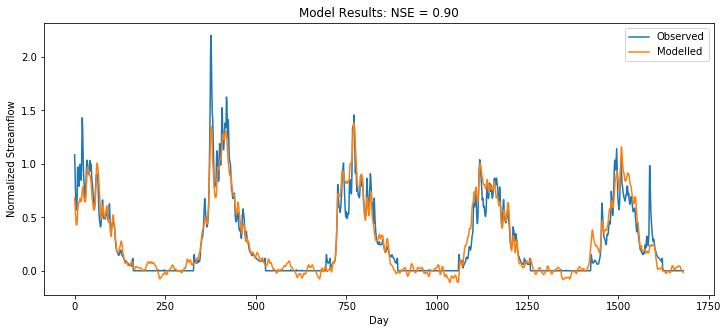

In [69]:
#visualize more

saveIt = 0

plt.figure(figsize = (12,5))
plt.plot(y_test, label = 'Observed')
plt.plot(y_testPredict, label = 'Modelled')
#plt.xlim((4500,6000))
plt.legend()
plt.xlabel('Day')
plt.ylabel('Normalized Streamflow')
plt.title('Model Results: NSE = ' + str(NSE)[:4])
#plt.show()

if saveIt:
  plt.savefig('modelled_time_series.png')

In [0]:
#investigate what the model is looking at in test set

day = 220
iters = 100
fracOnes = 0.9 #fraction to leave unmaksed
nones = int(365*fracOnes)
nzeros = 365 - nones
heat = np.zeros((1,365,5))

xday = np.reshape(x_test[day],(1,365,5))
yday = model.predict(xday)

for iter in range(iters):
  
  mask = np.hstack((np.ones(nones), np.zeros(nzeros)))
  np.random.shuffle(mask)
  mask = np.reshape(mask,(1,365,1))
  xday_mask = xday*mask
  yday_mask = model.predict(xday_mask)

  delta = np.abs(yday - yday_mask)
  heat += delta * (1 - mask)


  



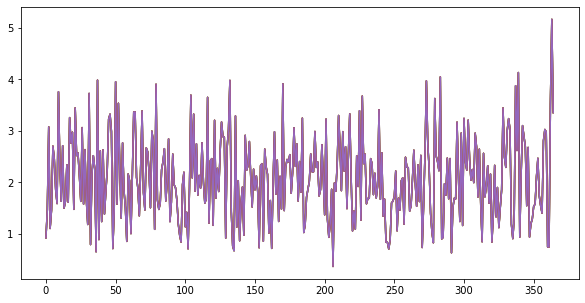

In [135]:
#visualize heatmap

plt.figure(figsize = (10,5))

plt.subplot(111)
plt.plot(np.squeeze(heat))
plt.show()

In [130]:
delta

array([[0.0718894]], dtype=float32)

In [79]:
n = 10
m = 10
a = np.hstack((np.ones(n), np.zeros(m)))
print(np.random.shuffle(a))

None


In [0]:
a = xday*mask

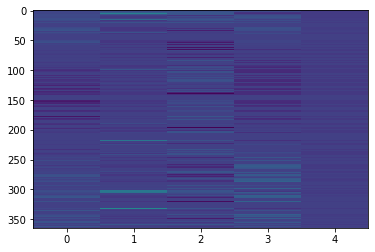

In [110]:
plt.imshow(np.squeeze(a),aspect='auto')

(0, 100)

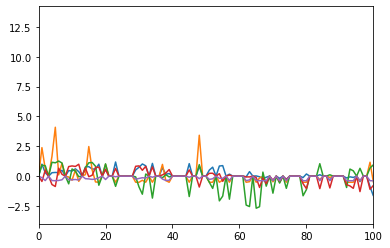

In [112]:
plt.plot(np.sum(a,axis=0))
plt.xlim((0,100))

In [50]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [94]:
import scipy
#def create_mask(h = 1, w = 10, H = 5, W = 365, p_1 = 0.7):

h = 2
w = 10
H = 5
W = 365
p_1 = 0.7

mask_small = np.random.choice([0,1], size = (h,w), p = [1-p_1, p_1])
x1 = [val for val in range(w)]
y1 = [val for val in range(h)]
x2 = [val * (w/W) for val in range(W)]
y2 = [val * (h/H) for val in range(H)]
f = scipy.interpolate.interp2d(x1,y1,mask_small,kind = 'linear')
mask_large = f(x2,y2,mask_small)

#return mask_small, mask_large

#mask_small, mask = create_mask()
plt.imshow(mask_large)


ValueError: ignored

In [93]:
mask_large

In [0]:
# create a random mask
def create_mask(h=7, w=7, H=224, W=224, p_1=0.5, resample=Image.BILINEAR):

    # create random hxw mask
    mask = np.random.choice([0, 1], size=(h, w), p=[1 - p_1, p_1])

    # resize
    mask = Image.fromarray(mask * 255.)
    mask = mask.resize((H + h, W + w), resample=resample)
    mask = np.array(mask)

    # crop to HxW
    w_crop = np.random.randint(0, w + 1)
    h_crop = np.random.randint(0, h + 1)
    mask = mask[h_crop:H + h_crop, w_crop:W + w_crop]

    # normalize
    mask /= np.max(mask)

    return mask